In [ ]:
from folium.plugins import MeasureControl, FloatImage
#from rasterio.warp import calculate_default_transform,reproject,Resampling
#from shapely import BufferCapStyle, BufferJoinStyle, buffer
#from shapely.geometry import shape, Point, Polygon
#from shapely.ops import transform
#from osgeo import gdal
#import matplotlib.pyplot as plt
#import rasterio as rio
#import rasterio.mask
import ipywidgets as widgets
import ipyleaflet
#import matplotlib
import subprocess
import geopandas as gpd
import pandas as pd
import altair as alt
import numpy as np
#import requests
import shapely
import pyproj
import folium
import branca
import base64
#import glob
#import pdal
import math
import json
import copy
import sys
import os
import io

In [ ]:
print(f"folium version: {folium.__version__}")
#print(f"GDAL version: {gdal.__version__}")
print(f"python version:{sys.version[:6]}")

In [ ]:
def stream_metrics(df):
    #finding slopes
    slopes = np.gradient(df['elevation_(m)'])
    max_slope = abs(slopes).max()

    ctr = int(len(df) / 2)
    thalweg = df['elevation_(m)'][ctr] #if water is present then this is baseflow not thalweg

    #initializing variables
    toe_rt = 0
    shoulder_rt = 0

    toe_lf = 0
    shoulder_lt =0

    dist_lf = None
    dist_rt = None

    stream_ht_lf = None
    stream_ht_rt = None

    for rt in range(ctr,len(df)):
        #print(rt, (rt*0.6), df['elevation_(m)'][rt], slopes[rt])
        if slopes[rt] > 0.07:
            toe_rt = 1 #or do I set elevation?
        if slopes[rt] < 0.05 and toe_rt == 1:
            shoulder_rt = 1
            dist_rt = rt * 0.6 #- 0.6
            bankfull_rt = df['elevation_(m)'][rt]
            stream_ht_rt = bankfull_rt - thalweg 
            break

    for lf in range(ctr,0,-1):
        #print(lf, (lf*0.6), df['elevation_(m)'][lf], slopes[lf])
        if slopes[lf] < -0.07:
            toe_lf = 1 #or do I set elevation?
        if slopes[lf] > -0.05 and toe_lf == 1:
            shoulder_lf = 1
            dist_lf = lf * 0.6 # 0.6
            bankfull_lf = df['elevation_(m)'][lf]
            stream_ht_lf = bankfull_lf - thalweg 
            break

    if dist_lf is not None and dist_rt is not None:
        #stream_w = (dist_rt) - abs(dist_lf)
        dl = abs(dist_lf) + 0.6
        dr = dist_rt - 0.6
        stream_w = dr - dl
    else: 
        stream_w = "invalid"
        dl = "invalid"
        dr = "invalid"

    if stream_ht_lf is not None and stream_ht_rt is not None:
        stream_ht = (stream_ht_lf + stream_ht_rt) /2
        bankfull = (bankfull_lf + bankfull_rt) / 2
    else:
        stream_ht = "invalid"
        bankfull = "invalid"

    return(stream_w, dl, dr, stream_ht, bankfull, max_slope)

In [ ]:
# os.chdir(r"C:\Users\jvonnonn\research_proj\incised_meadows\meadow_temp")
# Ask GRASS GIS where its Python packages are.
sys.path.append(
    subprocess.check_output(["grass8", "--config", "python_path"], text=True).strip()
)

# Import the GRASS GIS packages we need.
import grass.script as gs
import grass.jupyter as gj

import shutil
from pathlib import Path

# #checking if "temp_location" exists, then deleting
# dirpath = Path('temp_location')
# if dirpath.exists() and dirpath.is_dir():
#     shutil.rmtree(dirpath)

# !grass83 -c C:/Users/jvonnonn/research_proj/incised_meadows/meadow_temp/dtm_temp.tif -e C:/Users/jvonnonn/research_proj/incised_meadows/meadow_temp/temp_location

session = gj.init("/data/grassdata/meadow")

In [ ]:
os.environ["GRASS_PYTHON"] = sys.executable

In [ ]:
gs.run_command("r.external", input="dtm_temp.tif", output="dtm")
#gs.run_command("r.in.gdal", input="dtm_temp.tif", output="dtm_nofill")
#gs.run_command("r.fill.stats", input="dtm_nofill", distance=8, output="dtm")
gs.run_command("r.colors", map="dtm", color="elevation")

map = gj.Map()
map.d_rast(map='dtm')
map.show()

In [ ]:
gs.run_command("r.relief", input="dtm", output="dtm_relief")

map = gj.Map()
map.d_rast(map='dtm_relief')
map.show()

In [ ]:
gs.run_command("r.shade", shade="dtm_relief", color="dtm", output="dtm_shade")

map = gj.Map()
map.d_rast(map='dtm_shade')
map.show()

In [ ]:
#gs.run_command("r.external", input="dtm_temp.tif", output="dtm_nofill")
#gs.run_command("r.in.gdal", input="dtm_temp.tif", output="dtm_nofill")
#gs.run_command("r.fill.stats", input="dtm_nofill", distance=8, output="dtm")
#gs.run_command("r.colors", map="dtm", color="elevation")

#map = gj.Map()
#map.d_rast(map='dtm')
#map.show()

In [ ]:
gs.run_command("r.stream.extract", elevation="dtm", threshold=500,
                mexp=0.5, stream_length=500, memory=100000, stream_raster="stream_r",
                direction="direction_r", stream_vector="stream_vect")

map = gj.Map()
map.d_rast(map='direction_r')
map.d_vect(map='stream_vect', color="red", width=2)
map.show()

In [ ]:
gs.run_command("r.accumulate", direction="direction_r", format="auto", accumulation="accum",
               outlet="stream_vect", longest_flow_path="longest_stream")

gs.run_command("r.stream.order", stream_rast="stream_r", accumulation="accum", direction="direction_r",
                elevation="dtm", hack="stream_hack", stream_vect="stream_v")

# derive main channel
gs.run_command("v.extract", input="stream_v", where='"hack" = 1', output="main_channel")
gs.run_command("v.build.polylines", input="main_channel", output="polylines", cats="first")

map = gj.Map()
map.d_rast(map='dtm')
map.d_vect(map='polylines')
map.show()

In [ ]:
# get longest channel
lengths = gs.read_command("v.to.db", flags="p", map="polylines", type="line", option="length", columns="aa", separator=",")
df = pd.read_csv(io.StringIO(lengths))
cat = df.iloc[df['length'].idxmax(), 0]
gs.run_command("v.extract", input="polylines", output="plong", cat=cat)

map = gj.Map()
map.d_rast(map='dtm')
map.d_vect(map='plong')
map.show()

In [ ]:
gs.run_command("v.generalize", input="plong", type="line", method="snakes", threshold=1, output="plong_simp")

gs.run_command("v.out.ogr", input="plong_simp", output="lacey_plong_simp.geojson", format="GeoJSON")

In [ ]:
t = !v.to.db map=plong_simp option=sinuous columns=sinuosity -p

sino = t[1].split("|")[1]
sino

In [ ]:
# buffer
gs.run_command("v.buffer", input="plong_simp", output="plong_simp_buffer", type="line", distance=10)
# activate mask
gs.run_command("r.mask", vector="plong_simp_buffer")
# hand
gs.run_command("r.stream.distance", stream_rast="stream_r", direction="direction_r", elevation="dtm", difference="hand")
# deactivate mask
gs.run_command("r.mask", flags="r")
# reclassify (0:1:1 means values 0-1 will become 1)
#gs.write_command("r.recode", input="hand", output="hand_reclass", rules="-", stdin="\n".join(["-1:0:0", "0:1:1", "1:2:2", "2:3:3"]))
# set specific colors
#gs.write_command("r.colors", map="hand_reclass", rules="-", stdin="\n".join(["0 red", "1 green", "2 blue", "3 yellow"]))
# or simply choose a color ramp
gs.run_command("r.colors", map="hand", color="bcyr")

In [ ]:
map = gj.Map()
map.d_rast(map='hand')
map.d_vect(map='plong_simp')
map.show()

In [ ]:
gs.run_command("r.geomorphon", forms="forms", elevation="dtm", search=10, skip=3, flat=2.5)

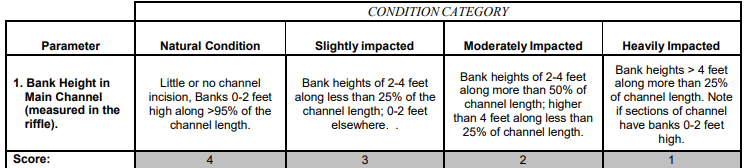

In [ ]:
# calculate bank height values using categories from American Rivers
#
gs.run_command("r.mask", raster="forms", maskcats=4)
# reclassify (0:1:1 means values 0-1 will become 1)
gs.write_command("r.recode", input="hand", output="hand_recode", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
stats = gs.read_command("r.stats", input="hand_recode", flags="na", separator="comma")
gs.run_command("r.mask", flags="r")
df = pd.read_csv(io.StringIO(stats), names=["category", "area"], index_col=0)
df["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df["percentage"] = df.area/df.area.sum() * 100
df

In [ ]:
# compute maximum curvature
gs.run_command("r.param.scale", input="dtm", output="maxcurvature", size=7, method="maxic")
# mask based on buffer
gs.run_command("r.mask", vector="plong_simp_buffer")
# convert stream to raster
gs.run_command("v.to.rast", type="line", input="plong_simp", output="plong_simp", use="value", flags="d")

# high cost around the start and end point of the stream to not let cost path route around
high_cost = 100000
gs.run_command("v.to.points", input="plong_simp", output="plong_simp_start", use="start")
gs.run_command("v.to.points", input="plong_simp", output="plong_simp_end", use="end")
gs.run_command("v.patch", input="plong_simp_start,plong_simp_end", output="plong_simp_start_end")
gs.run_command("v.to.rast", input="plong_simp_start_end", output="plong_simp_start_end", type="point", use="value", value=high_cost)
gs.run_command("r.grow", flags="m", input="plong_simp_start_end", output="plong_simp_start_end_buffer", radius=10)

baseline_cost = 100
curvature_threshold = 0.95

# create cost surface: places with high curvature are the lowest,
# stream is the highest, places with curvatures lower than a certain threshold are 100
gs.mapcalc(f"cost = if ( isnull(plong_simp), if ((1 - maxcurvature) < {curvature_threshold}, 1 - maxcurvature, {baseline_cost}), {high_cost})")
gs.run_command("r.patch", input=["plong_simp_start_end_buffer", "cost"], output="cost")

# create start and end points for least cost path
category = gs.read_command("v.category", input="plong_simp", type="line", option="print").strip()
offset = 20
side_offset = 5
gs.write_command("v.segment", input="plong_simp", output="start_point_right", rules="-", stdin=f"P 1 {category} {offset} {side_offset}")
gs.write_command("v.segment", input="plong_simp", output="start_point_left", rules="-", stdin=f"P 1 {category} {offset} -{side_offset}")
gs.write_command("v.segment", input="plong_simp", output="end_point_right", rules="-", stdin=f"P 1 {category} -{offset} {side_offset}")
gs.write_command("v.segment", input="plong_simp", output="end_point_left", rules="-", stdin=f"P 1 {category} -{offset} -{side_offset}")

# compute cumulative cost surface for each bank, start at the beginning of the stream
gs.run_command("r.cost", flags="k", input="cost", output="cumulative_cost_right", outdir="costdir_right", start_points="start_point_right")
gs.run_command("r.cost", flags="k", input="cost", output="cumulative_cost_left", outdir="costdir_left", start_points="start_point_left")
# compute LCP for each bank, start at the end of the stream
# resulting raster line will have values of HAND along 
gs.run_command("r.path", flags="c", input="costdir_right", vector_path="bank_right", raster_path="bank_right", values="hand", start_points="end_point_right")
gs.run_command("r.path", flags="c", input="costdir_left", vector_path="bank_left", raster_path="bank_left", values="hand", start_points="end_point_left")
# reclassify each bank
gs.write_command("r.recode", input="bank_right", output="bank_recode_right", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
gs.write_command("r.recode", input="bank_left", output="bank_recode_left", rules="-", stdin="\n".join(["0:0.6:1", "0.6:1.2:2", "1.2:3:3"]))
# both banks together
gs.run_command("r.patch", input="bank_recode_right,bank_recode_left", output="banks_recode")
stats_right = gs.read_command("r.stats", input="bank_recode_right", flags="na", separator="comma")
stats_left = gs.read_command("r.stats", input="bank_recode_left", flags="na", separator="comma")
stats_both = gs.read_command("r.stats", input="banks_recode", flags="na", separator="comma")
gs.run_command("r.mask", flags="r")


In [ ]:
map = gj.InteractiveMap()
map.add_raster('dtm_relief')
map.add_vector('plong_simp')
map.add_vector('bank_right')
map.add_vector('bank_left')
map.show()

In [ ]:
df = pd.read_csv(io.StringIO(stats_right), names=["category", "area"], index_col=0)
df["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df["percentage"] = df.area/df.area.sum() * 100
df

In [ ]:
df = pd.read_csv(io.StringIO(stats_left), names=["category", "area"], index_col=0)
df["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df["percentage"] = df.area/df.area.sum() * 100
df

In [ ]:
df = pd.read_csv(io.StringIO(stats_both), names=["category", "area"], index_col=0)
df["bank"] = ["0-2 feet", "2-4 feet", "4+ feet"]
df["percentage"] = df.area/df.area.sum() * 100
df

In [ ]:
gs.run_command("r.stream.distance", stream_rast="stream_r", direction="direction_r", elevation="dtm", difference="stream")

gs.run_command("v.transects", input="plong_simp", output="transects", dleft=10, dright=10,
               transect_spacing=10, transect_perpendicular="line", metric="along")
gs.run_command("v.to.points", input="transects", out="points", use="vertex")

result = gs.read_command("v.out.ascii", input="points", separator=",")
df = pd.DataFrame([row.rsplit(',',1) for row in result.splitlines()],
                  columns=["coors","cat"])
df = df.groupby('cat')['coors'].apply(','.join).reset_index()
df = df.astype({'cat':int}).sort_values(by=['cat'], ignore_index=True)
#df

In [ ]:
# try setting the altair Y scale with domainMin and domainMax -https://altair-viz.github.io/user_guide/generated/core/altair.Scale.html
# use DTM min and max to set domain scale?

df['color'] = 0
# try using bins, something like df.elevation.min rounded and subtract 1 meter?
widths = []
heights = []
#red_t = []
html = []
fdf = []
fdfval = []
val = []

for index, row in df.iterrows():
    profile = gs.read_command("r.profile", input="dtm",
                              coordinates=(row["coors"]))
    profile_df = pd.DataFrame([row.split() for row in profile.splitlines()],
                              columns=["distance_(m)", "elevation_(m)"]).apply(pd.to_numeric, errors='coerce')
    fdf.append(profile_df)
    w,dl,dr,h,b,ms = stream_metrics(profile_df)
    #print(index,w,dl,dr,h,b)

    if dl != "invalid" and dr !="invalid":
        heights.append(h)
        widths.append(w)
        #if ((w / h) < 6) or (ms > 0.35):
        if h >  0.5:
            if w/h < 4:
                #print(index, (w/h))
            #red_t.append(1)
                df.loc[index,'color'] = 1

            elif w/h < 5.5:
                df.loc[index,'color'] = 2

            elif w/h < 6.5:
                df.loc[index,'color'] = 3

        else:
            #red_t.append(0)
            df.loc[index,'color'] = 0
    else: 
        #red_t.append(2)
        df.loc[index,'color'] = 4

    chart = alt.Chart(profile_df).mark_line().encode(
        alt.X('distance_(m)'),
        #alt.Y('elevation_(m):Q',scale=alt.Scale(zero=False, nice=True))
        #alt.Y('elevation_(m):Q',scale=alt.Scale(domainMin=min_elev,domainMax=max_elev))
        alt.Y('elevation_(m):Q',scale=alt.Scale(domainMin=profile_df['elevation_(m)'].min() - 1,
                                                domainMax=profile_df["elevation_(m)"].max() + 1))
    ).properties(width=650,height=100) #600/100


    bankfull = alt.Chart(pd.DataFrame({'elevation_(m)': [b]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=2,
                                                            strokeCap='butt',
                                                            strokeDash=[4,4],
                                                            color='purple').encode(y='elevation_(m)')
    
    str_l = alt.Chart(pd.DataFrame({'distance_(m)': [dl]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=1,
                                                            strokeCap='butt',
                                                            strokeDash=[2,2],
                                                            color='red').encode(x='distance_(m)')

    str_r = alt.Chart(pd.DataFrame({'distance_(m)': [dr]})).mark_rule(
                                                            size=1,
                                                            strokeWidth=1,
                                                            strokeCap='butt',
                                                            strokeDash=[2,2],
                                                            color='green').encode(x='distance_(m)')

    #test = chart.to_dict()
    #test2 = bankfull.to_dict()
    #vega_lite = folium.VegaLite(line, width='100%',height='100%')
    if dl == "invalid" or dr == "invalid":
        all = chart
    else:
        all = chart + bankfull + str_l + str_r
        
    convert = all.to_dict()

    html.append(convert)
    val.append([index,w,dl,dr,h,b,ms])

In [ ]:
total_width = sum(widths)
avg_width = total_width / len(widths)
print(avg_width)

total_height = sum(heights)
avg_height = total_height / len(heights)
print(avg_height)

In [ ]:
#gs.run_command("v.out.ogr", input="transects", output="transects.geojson", format="GeoJSON")
trnscts = gpd.read_file('transects.geojson').to_crs(4326)
trnscts['html'] = html
trnscts['color'] = df['color']

In [ ]:
gs.run_command("v.in.ogr", input="meadow_extent.geojson", output="meadow_extent")
meadow_extent = gs.parse_command("g.region", vector="meadow_extent", flags="ucgl")
loc = (float(meadow_extent["center_long"]), float(meadow_extent["center_lat"]))

In [ ]:
def transect_style(color): #change red to color
    if color == 1:
        style = lambda x:{'color':'red','weight':3,'dashArray':"4,8"}
    elif color == 2:
        style = lambda x:{'color':'orange','weight':3,'dashArray':"4,8"}
    elif color == 3:
        style = lambda x:{'color':'yellow','weight':3,'dashArray':"4,8"}
    elif color == 4:
        style = lambda x:{'color':'grey','weight':3,'dashArray':"4,8"}
    else:
        style = lambda x:{'color':'purple','weight':3,'dashArray':"4,8"}
    return style

In [ ]:
# Add custom base maps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

# Add custom basemaps
basemaps['Google Maps'].add_to(m)

In [ ]:
m = folium.Map(location=[loc[1], loc[0]], zoom_start=14, max_zoom=20)

map_title = "Stream Metrics"
title_style = "position:absolute;z-index:10000;left:5vw;top:1vw;color:orange;font-size:16px;font-weight:bold"
metrics1 = f"Sinousity: {round(float(sino),3)}"
metrics2 = f"Width/Depth: {round((avg_width/avg_height),3)}"
metrics_style = "position:absolute;z-index:9000;left:5vw;top:5vw;color:white;font-size:14px"
title_html = f'<p style={metrics_style}>{metrics1}<br>{metrics2}<p><h1 style={title_style}>{map_title}</h1>'
m.get_root().html.add_child(folium.Element(title_html))

#adding USGS logo *does not resize properly
image_usgs = "data\\USGS.png" #maybe point this to a url?
with open(image_usgs, 'rb') as lf:
   #open in binary mode, read bytes, encode, decode obtained bytes as utf-8 string
   b64_content = base64.b64encode(lf.read()).decode('utf-8') 
FloatImage('data:image/png;base64,{}'.format(b64_content), bottom=0, left=0, width='8%',height='7%').add_to(m)

# Adding my_custom_style to the map
#m.get_root().add_child(my_custom_style)



gj.Raster('dtm_shade',show=False).add_to(m) #DTM causing Folium to not save map. Can't convert to HTML string?
gj.Raster('forms','geomorphons', opacity=0.7,show=False).add_to(m)
gj.Raster('hand',show=False, opacity=0.7).add_to(m) 
gj.Vector('plong_simp','main channel').add_to(m)
gj.Vector(
          'meadow_extent',
          show=False,
          color='red',
          fill=False
          ).add_to(m)

fg =folium.FeatureGroup(name='Transects').add_to(m)
for _, s in trnscts.iterrows():
    graph = s['html']
    coords = list(s['geometry'].coords)
    ttip = s['cat']

    geo_data={"type":"Polygon","coordinates":[coords]}
    geo_obj=folium.GeoJson(geo_data, style_function=transect_style(s['color']),
                            highlight_function=lambda x:{'color':'yellow','weight':8},
                            opacity=0.7,
                            tooltip=folium.Tooltip(ttip),
                            popup=folium.Popup().add_child(folium.VegaLite(graph,width="100%")),
                            #popup_keep_highlighted=True, #needs python 3.9?
                            )
    #geo_obj.add_child(folium.Popup(max_width=650).add_child(folium.VegaLite(graph)))
    geo_obj.add_to(fg)    
m.add_child(folium.LayerControl())
m.add_child(MeasureControl())

In [ ]:
m.save('stream_metrics.html')

In [ ]:
print(f'Purple = {sum(trnscts.color == 0)}, {sum(trnscts.color == 0)/len(trnscts)*100}')
print(f'Red = {sum(trnscts.color == 1)}')
print(f'Orange = {sum(trnscts.color == 2)}')
print(f'Yellow = {sum(trnscts.color == 3)}')
print(f'Grey = {sum(trnscts.color == 4)}')

print(f'Total = {len(trnscts)}')